SETUP AND OBSERVATIONAL ANALYSIS

In [239]:
# Importing libraries/functions to be used
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split

In [240]:
# Import dataset from yahoo finance consisting of [Date, Opening Price, Closing Price]
dataset = yf.download(tickers = "^GSPC", start="2023-10-26", end="2024-10-25")
dataset = dataset[['Open', 'Close']]
dataset = dataset.reset_index()
dataset

[*********************100%%**********************]  1 of 1 completed

,Date,Open,Close
0,2023-10-26,4175.990234,4137.229980
1,2023-10-27,4152.930176,4117.370117
2,2023-10-30,4139.390137,4166.819824
3,2023-10-31,4171.330078,4193.799805
4,2023-11-01,4201.270020,4237.859863
...,...,...,...
246,2024-10-18,5859.430176,5864.669922
247,2024-10-21,5857.819824,5853.979980
248,2024-10-22,5832.700195,5851.200195
249,2024-10-23,5834.500000,5797.419922


In [241]:
# Transform the raw data into a pandas dataframe consisting of [Date, OPS]
# OPS = ((Opening Price - Closing Price of previous day) / Closing Price of previous day) * 100
# i.e. it refers to the percentage change in price overnight
ops = []
for i in range(1, len(dataset['Open'] + 1)):
    result = ((dataset['Open'][i] - dataset['Close'][i-1]) / dataset['Close'][i-1]) * 100
    ops.append(result)
ops = pd.DataFrame({'OPS': ops})

time_series = pd.concat([dataset['Date'], ops], axis=1)
time_series = time_series.dropna()
#time_series['OPS'] = time_series['OPS'].shift(1)
#time_series = time_series.drop(len(time_series)-1)
#time_series = time_series.drop(index=1)
#time_series = time_series.reset_index()
#time_series = time_series.drop(['index'], axis=1)
for i in range(len(time_series)):
    if time_series['OPS'][i] < -3:
        print(time_series['Date'][i])
        print(time_series['OPS'][i])
time_series

2024-08-02 00:00:00
-3.6550589488075302


,Date,OPS
0,2023-10-26,0.379486
1,2023-10-27,0.534808
2,2023-10-30,0.108242
3,2023-10-31,0.178125
4,2023-11-01,0.717341
...,...,...
245,2024-10-17,0.307456
246,2024-10-18,-0.116803
247,2024-10-21,-0.363510
248,2024-10-22,-0.285415


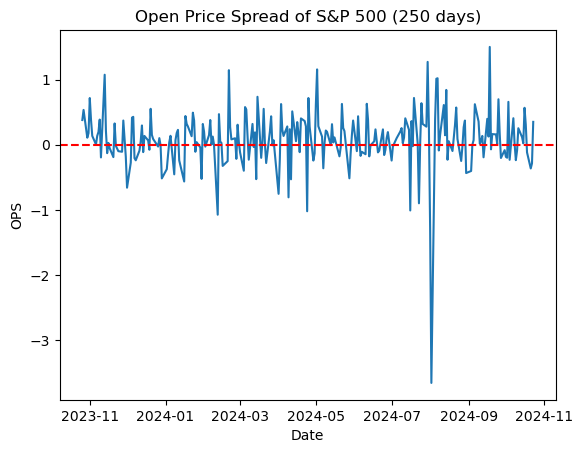

In [242]:
# Plotting the time series data (OPS) for observing trends and seasons
plt.plot(time_series['Date'], time_series['OPS'])
plt.axhline(y=0, linestyle='--', color='red')
plt.title('Open Price Spread of S&P 500 (' + str(len(time_series['OPS'])) + ' days)')
plt.xlabel('Date')
plt.ylabel('OPS')
plt.show()

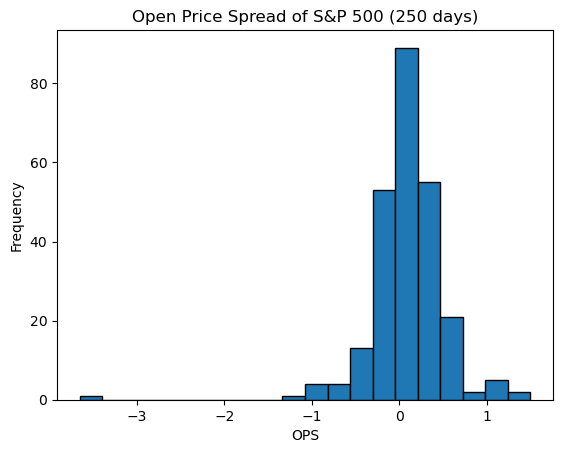

In [243]:
# Plotting the spread of OPS
plt.hist(time_series['OPS'], bins=20, edgecolor="black")
plt.title('Open Price Spread of S&P 500 (' + str(len(time_series['OPS'])) + ' days)')
plt.xlabel('OPS')
plt.ylabel('Frequency')
plt.show()

ARIMA MODEL

These were used as guides during the creation of this model:

Forecasting Time Series with Auto-Arima, Data Science Portfolio, alldatascience.com <https://www.alldatascience.com/time-series/forecasting-time-series-with-auto-arima/>

How to Create an ARIMA Model for Time Series Forecasting in Python, Jason Brownlee, machinelearningmaster.com <https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/>

Interrupted time series analysis using autoregressive integrated moving average (ARIMA) models: a guide for evaluating large-scale health interventions, Schaffer A et al., PubMed <https://pmc.ncbi.nlm.nih.gov/articles/PMC7986567/>

In [244]:
# Check to see if data is stationary using the Augmented Dicky Fuller Test (adfuller)
# Stationary data is required for timeseries analysis/prediction
data = time_series['OPS']
stationary_check = adfuller(data)
print('ADF Statistic: ', stationary_check[0])
print('p-value: ', stationary_check[1])
if(stationary_check[1] < 0.05):
    print('Data is stationary')
else:
    print('Data is not stationary')

ADF Statistic:  -8.802209492008524
p-value:  2.0974456447278634e-14
Data is stationary


c:\Users\olive\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


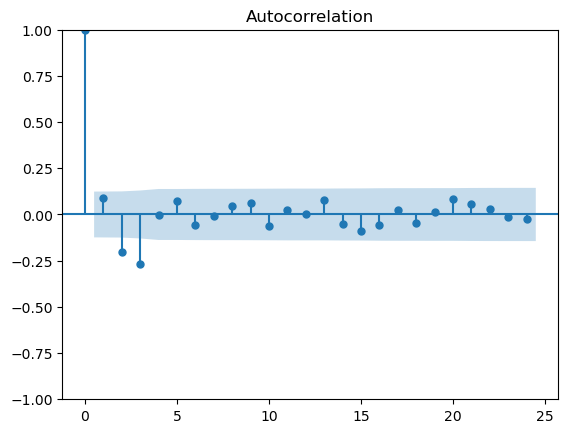

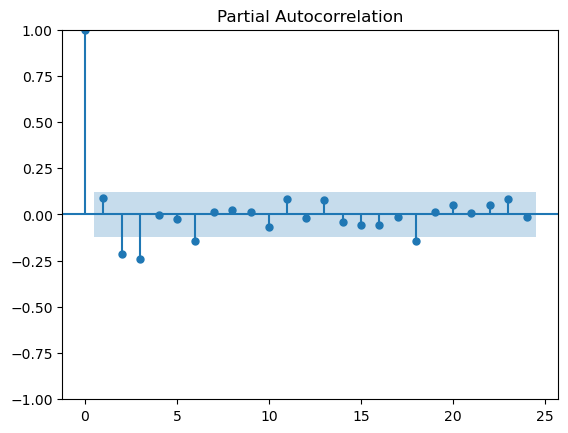

In [245]:
# Autocorrelation and partial autocorrelation graphs
plot_acf(data)
plot_pacf(data)
plt.show()

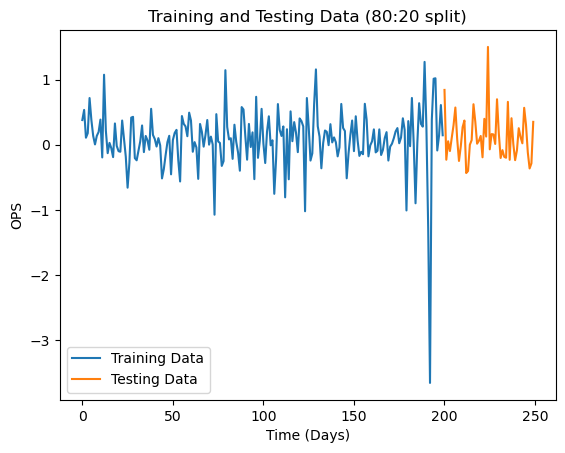

In [246]:
# Split data into 80% training set and 20% testing set
train_data, test_data = train_test_split(data, test_size=0.20, shuffle=False)
plt.plot(train_data, label="Training Data")
plt.plot(test_data, label="Testing Data")
plt.title("Training and Testing Data (80:20 split)")
plt.xlabel("Time (Days)")
plt.ylabel("OPS")
plt.legend()
plt.show()

In [247]:
# Due to being unable to determine the p and q parameters for the arima model, 
# an auto-arima algorithm will be used which selects the p, d and q parameters automatically
# decided on (3, 0, 0)

# Fitting model
#model = auto_arima(train_data, seasonal=False, stepwise=True) 
# Due to the auto_arima algorithm being inconsistent, swtiched back to manual (parameters of 3, 0, 0  were still initially selected by auto_arima)
model = ARIMA(train_data, order=(3, 0, 0)) 
model = model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                    OPS   No. Observations:                  200
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -117.107
Date:                Sat, 26 Oct 2024   AIC                            244.213
Time:                        17:37:16   BIC                            260.705
Sample:                             0   HQIC                           250.887
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0747      0.028      2.630      0.009       0.019       0.130
ar.L1          0.0699      0.077      0.907      0.364      -0.081       0.221
ar.L2         -0.2189      0.085     -2.583      0.0

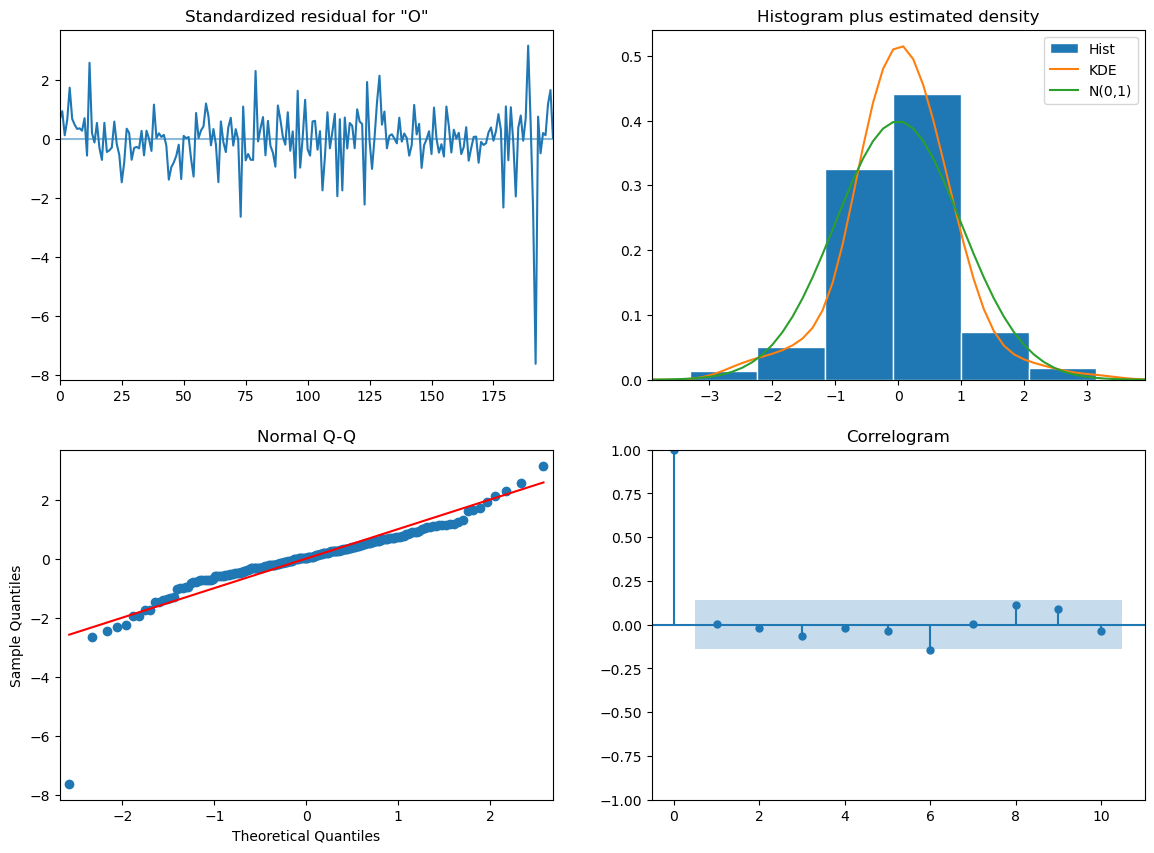

In [248]:
# Plotting diagnostics/residual plots
model.plot_diagnostics(figsize=(14,10))
plt.show()

PREDICTION

In [249]:
# Making prediction
prediction = model.forecast(steps=len(test_data))
print(prediction)

200   -0.053601
201   -0.074142
202    0.075873
203    0.137214
204    0.113441
205    0.063497
206    0.050956
207    0.066534
208    0.081973
209    0.082556
210    0.075599
211    0.071397
212    0.072491
213    0.075103
214    0.076023
215    0.075261
216    0.074400
217    0.074293
218    0.074651
219    0.074899
220    0.074863
221    0.074723
222    0.074663
223    0.074698
224    0.074746
225    0.074756
226    0.074738
227    0.074723
228    0.074724
229    0.074732
230    0.074735
231    0.074734
232    0.074731
233    0.074730
234    0.074731
235    0.074732
236    0.074732
237    0.074732
238    0.074732
239    0.074732
240    0.074732
241    0.074732
242    0.074732
243    0.074732
244    0.074732
245    0.074732
246    0.074732
247    0.074732
248    0.074732
249    0.074732
Name: predicted_mean, dtype: float64


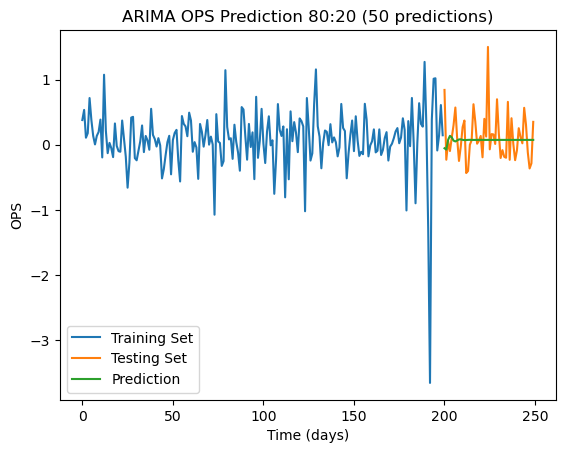

In [250]:
# Saving confidence limits
#cf = pd.DataFrame(confint)

# Plot final results
plt.plot(train_data, label='Training Set')
plt.plot(test_data, label='Testing Set')
plt.plot(prediction, label='Prediction')
#plt.fill_between(prediction.index,cf[0], cf[1], color='grey', alpha=0.3, label='Confidence Limits')
plt.title('ARIMA OPS Prediction 80:20 (' + str(len(prediction)) + ' predictions)')
plt.xlabel('Time (days)')
plt.ylabel('OPS')
plt.legend()
plt.show()

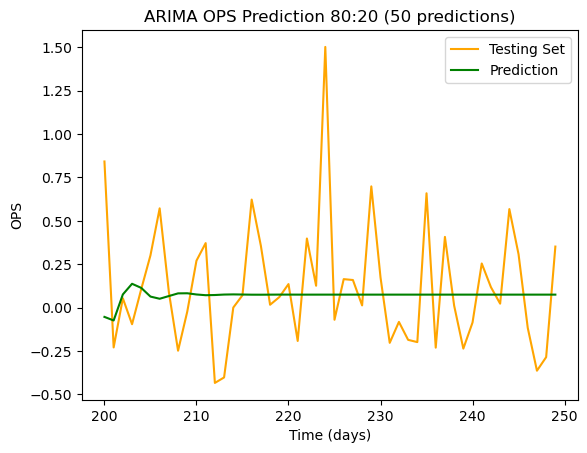

In [251]:
# Plot Test set and prediction to get a close up comparison
plt.plot(test_data, label='Testing Set', color='orange')
plt.plot(prediction, label='Prediction', color='green')
#plt.fill_between(prediction.index,cf[0], cf[1], color='grey', alpha=0.3, label='Confidence Limits')
plt.title('ARIMA OPS Prediction 80:20 (' + str(len(prediction)) + ' predictions)')
plt.xlabel('Time (days)')
plt.ylabel('OPS')
plt.legend()
plt.show()

EVALUATION

In [252]:
# Calculate accuracy measures mean squared error, mean absolute error and r squared value
mse = mean_squared_error(test_data, prediction)
mae = mean_absolute_error(test_data, prediction)
#mape = mean_absolute_percentage_error(test_data, prediction)
r2 = r2_score(test_data, prediction)
def calcsmape(actual, forecast):
    return 1/len(actual) * np.sum(2 * np.abs(forecast-actual) / (np.abs(actual) + np.abs(forecast)))
#smae = calcsmape(test_data, prediction)

print(mse)
print(mae)
#print(mape)
print(r2)
#print(smae)

0.13343225962777777
0.26429754122447213
-0.0502194878861113


In [253]:
# Save accuracy measures in a dataframe/table
accuracy_table = pd.DataFrame({'Train:Test Split' : "80:20",'Mean Squared Error' : mse, 'Mean Absolute Error' : mae, 'R-Squared Value' : r2}, index=["80:20"])
accuracy_table = accuracy_table.set_index('Train:Test Split')
accuracy_table

,Mean Squared Error,Mean Absolute Error,R-Squared Value
Train:Test Split,,,
80:20,0.133432,0.264298,-0.050219


The experiment was then repeated for smaller testing/prediction sizes and bigger training sizes

TEST SIZE = 10%

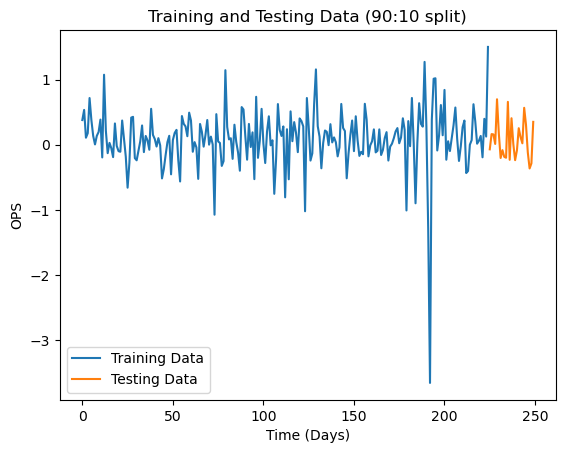

                               SARIMAX Results                                
Dep. Variable:                    OPS   No. Observations:                  225
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -130.061
Date:                Sat, 26 Oct 2024   AIC                            270.123
Time:                        17:37:18   BIC                            287.203
Sample:                             0   HQIC                           277.017
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0843      0.026      3.242      0.001       0.033       0.135
ar.L1          0.0665      0.074      0.899      0.369      -0.078       0.211
ar.L2         -0.1962      0.082     -2.394      0.0

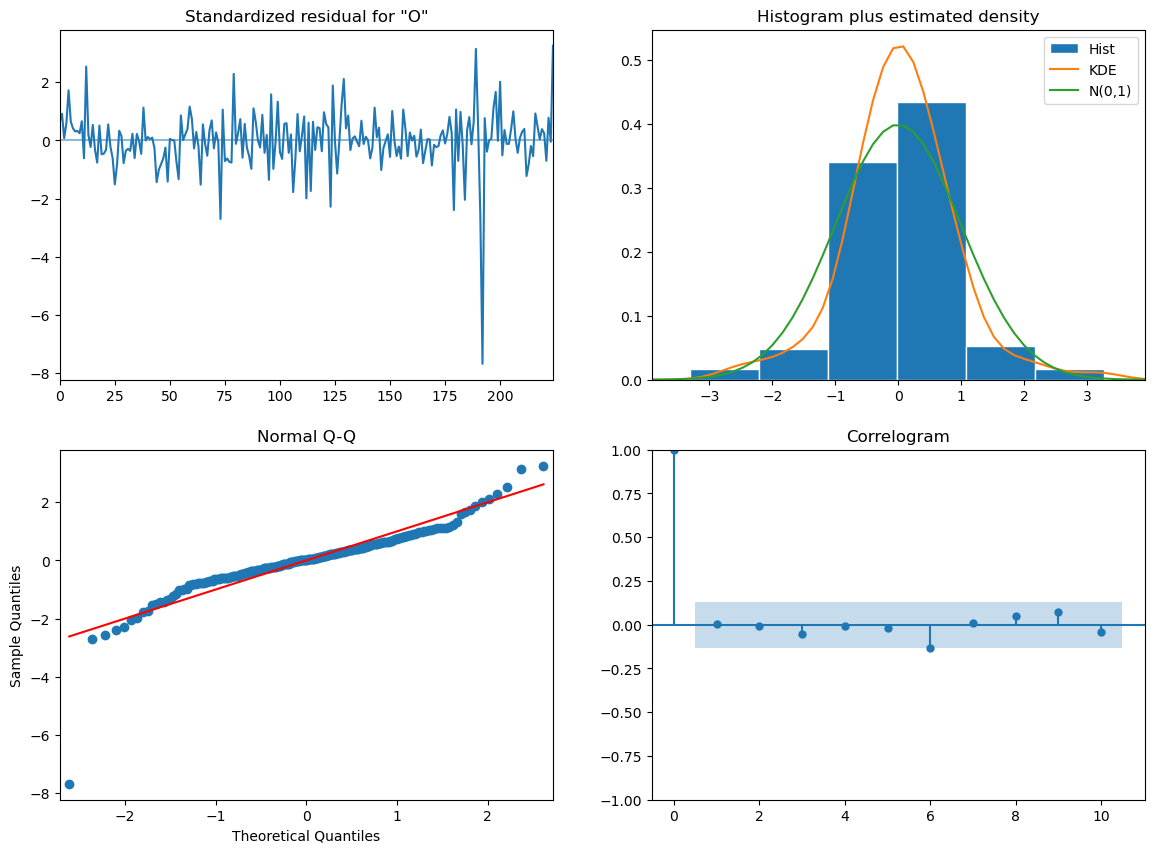

225    0.092244
226   -0.203620
227   -0.289341
228    0.113990
229    0.231296
230    0.181310
231    0.054536
232    0.026704
233    0.062173
234    0.101560
235    0.104151
236    0.087763
237    0.076357
238    0.078169
239    0.084608
240    0.087521
241    0.086000
242    0.083724
243    0.083146
244    0.083933
245    0.084665
246    0.084704
247    0.084366
248    0.084154
249    0.084197
Name: predicted_mean, dtype: float64


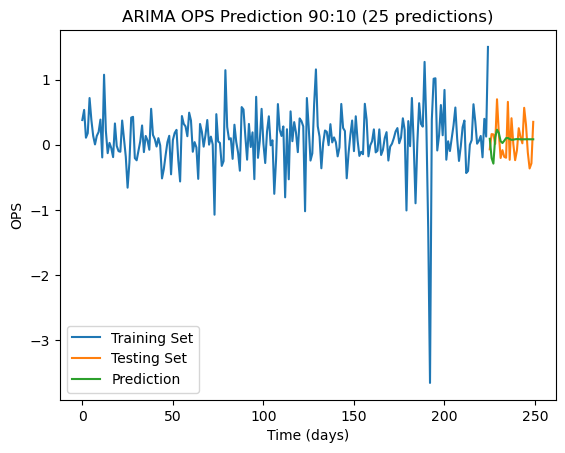

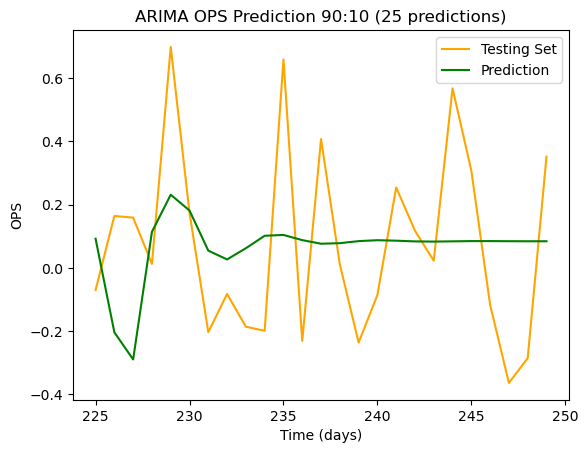

,Mean Squared Error,Mean Absolute Error,R-Squared Value
Train:Test Split,,,
80:20,0.133432,0.264298,-0.050219
90:10,0.089694,0.259548,-0.056176


In [254]:
# Split data
train_data, test_data = train_test_split(data, test_size=0.10, shuffle=False)
plt.plot(train_data, label="Training Data")
plt.plot(test_data, label="Testing Data")
plt.title("Training and Testing Data (90:10 split)")
plt.xlabel("Time (Days)")
plt.ylabel("OPS")
plt.legend()
plt.show()

# Fitting model
#model = auto_arima(train_data, seasonal=False, stepwise=True) 

# Due to the auto_arima algorithm being inconsistent, swtiched back to manual (parameters of 3, 0, 0  were still initially selected by auto_arima)
model = ARIMA(train_data, order=(3, 0, 0)) 
model = model.fit()
print(model.summary())

# Plotting diagnostics/residual plots
model.plot_diagnostics(figsize=(14,10))
plt.show()

# Making prediction
prediction = model.forecast(steps=len(test_data))
print(prediction)

# Plot (full size)
plt.plot(train_data, label='Training Set')
plt.plot(test_data, label='Testing Set')
plt.plot(prediction, label='Prediction')
#plt.fill_between(prediction.index,cf[0], cf[1], color='grey', alpha=0.3, label='Confidence Limits')
plt.title('ARIMA OPS Prediction 90:10 (' + str(len(prediction)) + ' predictions)')
plt.xlabel('Time (days)')
plt.ylabel('OPS')
plt.legend()
plt.show()

# Plot (Zoomed in)
plt.plot(test_data, label='Testing Set', color='orange')
plt.plot(prediction, label='Prediction', color='green')
#plt.fill_between(prediction.index,cf[0], cf[1], color='grey', alpha=0.3, label='Confidence Limits')
plt.title('ARIMA OPS Prediction 90:10 (' + str(len(prediction)) + ' predictions)')
plt.xlabel('Time (days)')
plt.ylabel('OPS')
plt.legend()
plt.show()

# Evaluate
mse = mean_squared_error(test_data, prediction)
mae = mean_absolute_error(test_data, prediction)
#mape = mean_absolute_percentage_error(test_data, prediction)
r2 = r2_score(test_data, prediction)
#smae = calcsmape(test_data, prediction)
accuracy_table.loc["90:10"] = {'Mean Squared Error' : mse, 'Mean Absolute Error' : mae, 'R-Squared Value' : r2}
accuracy_table

TEST SIZE = 5%

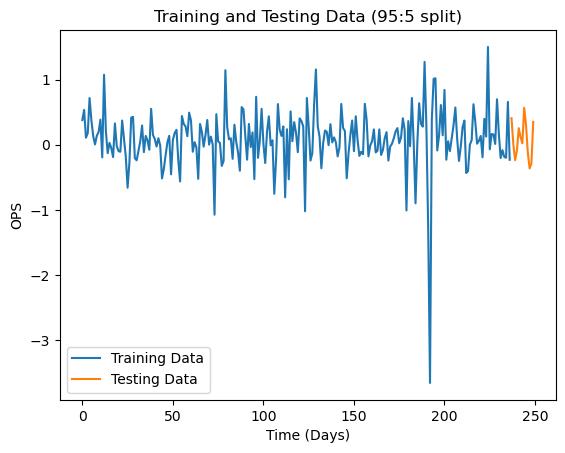

                               SARIMAX Results                                
Dep. Variable:                    OPS   No. Observations:                  237
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -134.944
Date:                Sat, 26 Oct 2024   AIC                            279.888
Time:                        17:37:20   BIC                            297.229
Sample:                             0   HQIC                           286.877
                                - 237                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0856      0.025      3.396      0.001       0.036       0.135
ar.L1          0.0563      0.073      0.774      0.439      -0.086       0.199
ar.L2         -0.1853      0.080     -2.316      0.0

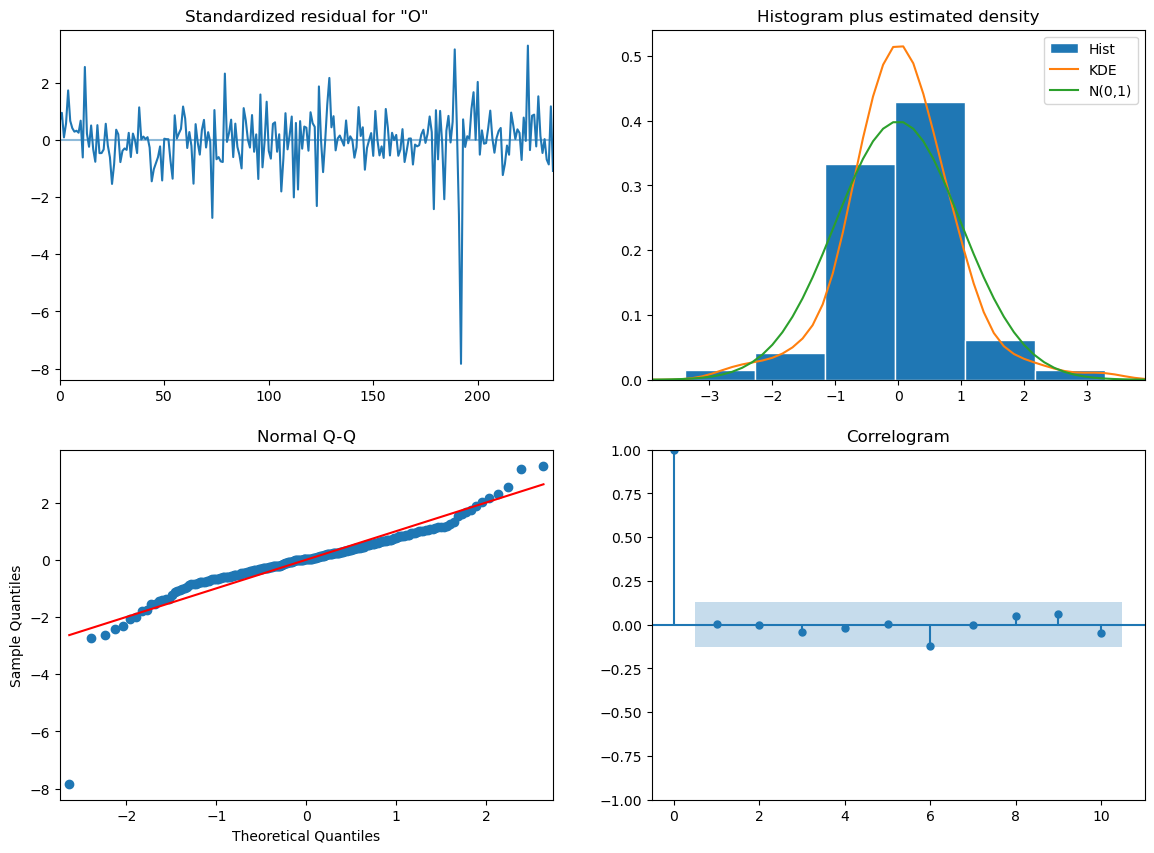

237    0.028985
238    0.005377
239    0.166513
240    0.118456
241    0.091482
242    0.060712
243    0.075358
244    0.088272
245    0.093571
246    0.088008
247    0.083655
248    0.083186
249    0.085284
Name: predicted_mean, dtype: float64


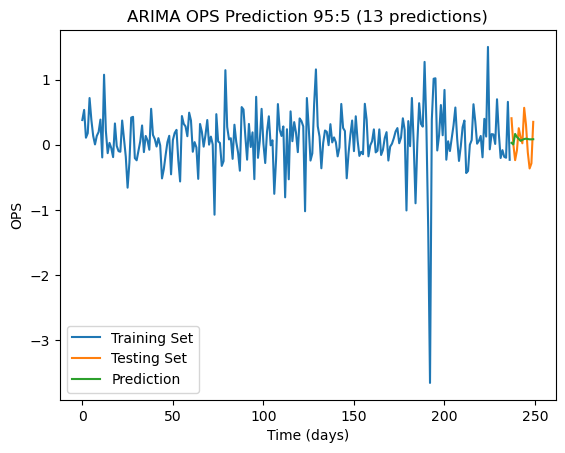

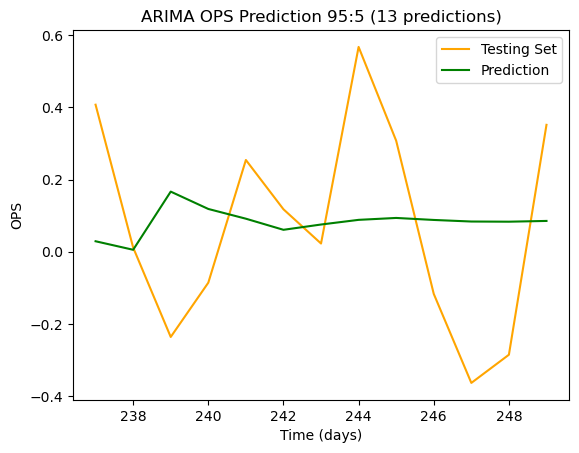

,Mean Squared Error,Mean Absolute Error,R-Squared Value
Train:Test Split,,,
80:20,0.133432,0.264298,-0.050219
90:10,0.089694,0.259548,-0.056176
95:5,0.084885,0.249509,-0.097260


In [255]:
# Split data
train_data, test_data = train_test_split(data, test_size=0.05, shuffle=False)
plt.plot(train_data, label="Training Data")
plt.plot(test_data, label="Testing Data")
plt.title("Training and Testing Data (95:5 split)")
plt.xlabel("Time (Days)")
plt.ylabel("OPS")
plt.legend()
plt.show()

# Fitting model
#model = auto_arima(train_data, seasonal=False, stepwise=True) 

# Due to the auto_arima algorithm being inconsistent, swtiched back to manual (parameters of 3, 0, 0  were still initially selected by auto_arima)
model = ARIMA(train_data, order=(3, 0, 0)) 
model = model.fit()
print(model.summary())

# Plotting diagnostics/residual plots
model.plot_diagnostics(figsize=(14,10))
plt.show()

# Making prediction
prediction = model.forecast(steps=len(test_data))
print(prediction)

# Plot (full size)
plt.plot(train_data, label='Training Set')
plt.plot(test_data, label='Testing Set')
plt.plot(prediction, label='Prediction')
#plt.fill_between(prediction.index,cf[0], cf[1], color='grey', alpha=0.3, label='Confidence Limits')
plt.title('ARIMA OPS Prediction 95:5 (' + str(len(prediction)) + ' predictions)')
plt.xlabel('Time (days)')
plt.ylabel('OPS')
plt.legend()
plt.show()

# Plot (Zoomed in)
plt.plot(test_data, label='Testing Set', color='orange')
plt.plot(prediction, label='Prediction', color='green')
#plt.fill_between(prediction.index,cf[0], cf[1], color='grey', alpha=0.3, label='Confidence Limits')
plt.title('ARIMA OPS Prediction 95:5 (' + str(len(prediction)) + ' predictions)')
plt.xlabel('Time (days)')
plt.ylabel('OPS')
plt.legend()
plt.show()

# Evaluate
mse = mean_squared_error(test_data, prediction)
mae = mean_absolute_error(test_data, prediction)
#mape = mean_absolute_percentage_error(test_data, prediction)
r2 = r2_score(test_data, prediction)
#smae = calcsmape(test_data, prediction)
accuracy_table.loc["95:5"] = {'Mean Squared Error' : mse, 'Mean Absolute Error' : mae, 'R-Squared Value' : r2}
accuracy_table

TEST SIZE = 2.5%

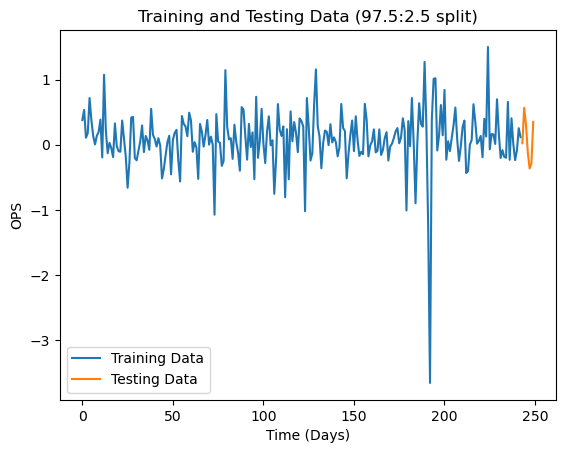

                               SARIMAX Results                                
Dep. Variable:                    OPS   No. Observations:                  243
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -136.101
Date:                Sat, 26 Oct 2024   AIC                            282.203
Time:                        17:37:22   BIC                            299.668
Sample:                             0   HQIC                           289.237
                                - 243                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0855      0.025      3.466      0.001       0.037       0.134
ar.L1          0.0538      0.072      0.752      0.452      -0.086       0.194
ar.L2         -0.1829      0.078     -2.331      0.0

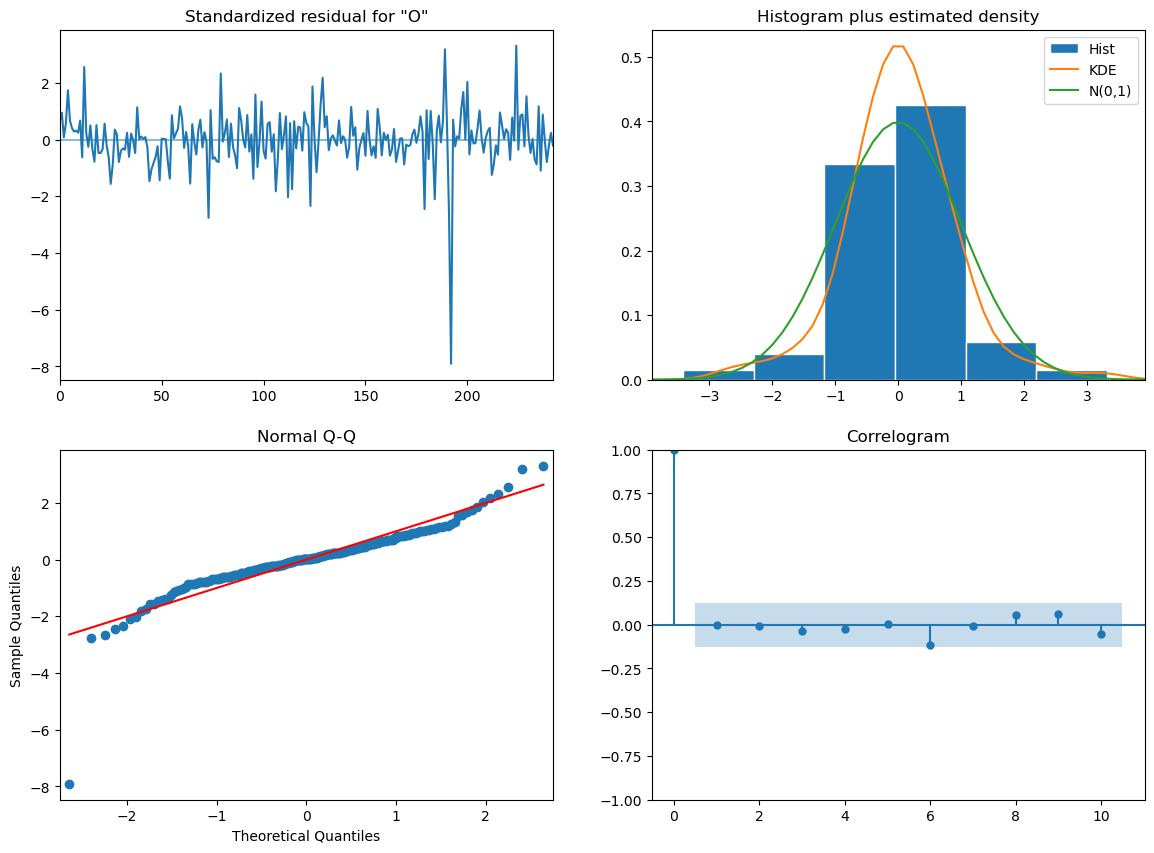

243    0.097125
244    0.040101
245    0.073282
246    0.090365
247    0.098785
248    0.088217
249    0.082043
Name: predicted_mean, dtype: float64


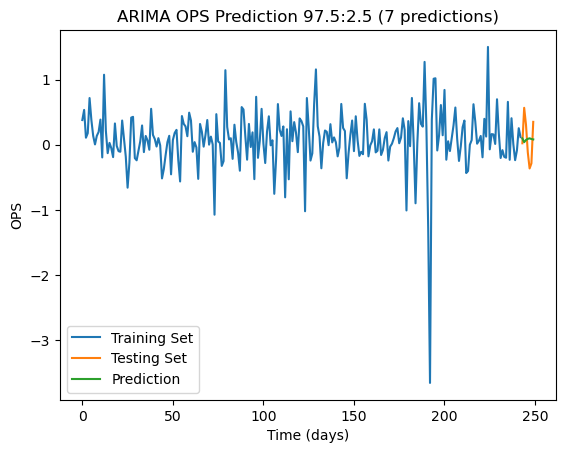

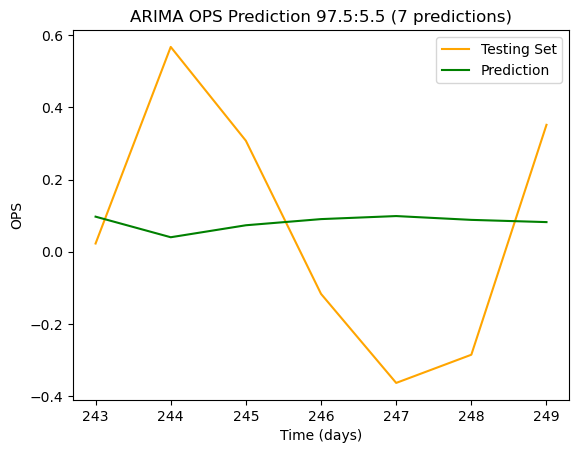

,Mean Squared Error,Mean Absolute Error,R-Squared Value
Train:Test Split,,,
80:20,0.133432,0.264298,-0.050219
90:10,0.089694,0.259548,-0.056176
95:5,0.084885,0.249509,-0.097260
97.5:2.5,0.115325,0.306925,-0.099194


In [256]:
# Split data
train_data, test_data = train_test_split(data, test_size=0.025, shuffle=False)
plt.plot(train_data, label="Training Data")
plt.plot(test_data, label="Testing Data")
plt.title("Training and Testing Data (97.5:2.5 split)")
plt.xlabel("Time (Days)")
plt.ylabel("OPS")
plt.legend()
plt.show()

# Fitting model
#model = auto_arima(train_data, seasonal=False, stepwise=True) 

# Due to the auto_arima algorithm being inconsistent, swtiched back to manual (parameters of 3, 0, 0  were still initially selected by auto_arima)
model = ARIMA(train_data, order=(3, 0, 0)) 
model = model.fit()
print(model.summary())

# Plotting diagnostics/residual plots
model.plot_diagnostics(figsize=(14,10))
plt.show()

# Making prediction
prediction = model.forecast(steps=len(test_data))
print(prediction)

# Plot (full size)
plt.plot(train_data, label='Training Set')
plt.plot(test_data, label='Testing Set')
plt.plot(prediction, label='Prediction')
#plt.fill_between(prediction.index,cf[0], cf[1], color='grey', alpha=0.3, label='Confidence Limits')
plt.title('ARIMA OPS Prediction 97.5:2.5 (' + str(len(prediction)) + ' predictions)')
plt.xlabel('Time (days)')
plt.ylabel('OPS')
plt.legend()
plt.show()

# Plot (Zoomed in)
plt.plot(test_data, label='Testing Set', color='orange')
plt.plot(prediction, label='Prediction', color='green')
#plt.fill_between(prediction.index,cf[0], cf[1], color='grey', alpha=0.3, label='Confidence Limits')
plt.title('ARIMA OPS Prediction 97.5:5.5 (' + str(len(prediction)) + ' predictions)')
plt.xlabel('Time (days)')
plt.ylabel('OPS')
plt.legend()
plt.show()

# Evaluate
mse = mean_squared_error(test_data, prediction)
mae = mean_absolute_error(test_data, prediction)
#mape = mean_absolute_percentage_error(test_data, prediction)
r2 = r2_score(test_data, prediction)
#smae = calcsmape(test_data, prediction)
accuracy_table.loc["97.5:2.5"] = {'Mean Squared Error' : mse, 'Mean Absolute Error' : mae, 'R-Squared Value' : r2}
accuracy_table

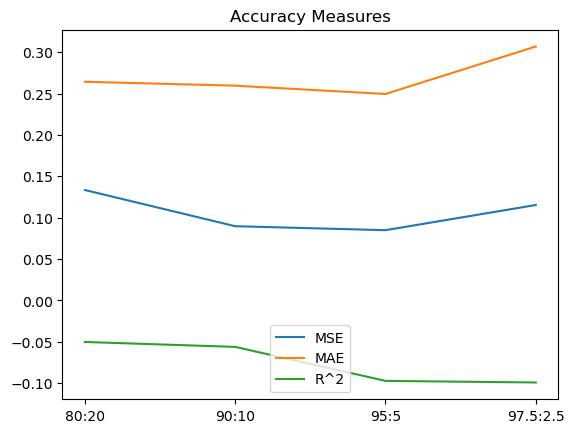

In [257]:
# Graph accuracy table
plt.plot(accuracy_table['Mean Squared Error'], label='MSE')
plt.plot(accuracy_table['Mean Absolute Error'], label='MAE')
#plt.plot(accuracy_table['Mean Absolute Percentage Error'], label='MAPE')
plt.plot(accuracy_table['R-Squared Value'], label='R^2')
#plt.plot(accuracy_table['Symmetric Mean Absolute Error'], label='SMAE')
plt.title('Accuracy Measures')
plt.legend()
plt.show()